## REFIT Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = (25, 15)

In [3]:
path="/Users/daniel.bustillo/Documents/thesis/REFIT"
os.chdir(path)

In [6]:
list_of_names= []
list_of_names=os.listdir(path)



In [46]:
  
# create empty list
dataframes_list = []
  
# append datasets into teh list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv(list_of_names[i], parse_dates=True, index_col=0, infer_datetime_format=True)
    dataframes_list.append(temp_df)

In [47]:
dataframes_list = [df.resample("1H").mean() for df in dataframes_list]
dataframes_list = [df.drop(['Unix','Issues'], axis=1) for df in dataframes_list]

Text(0.5, 1.0, 'House 12')

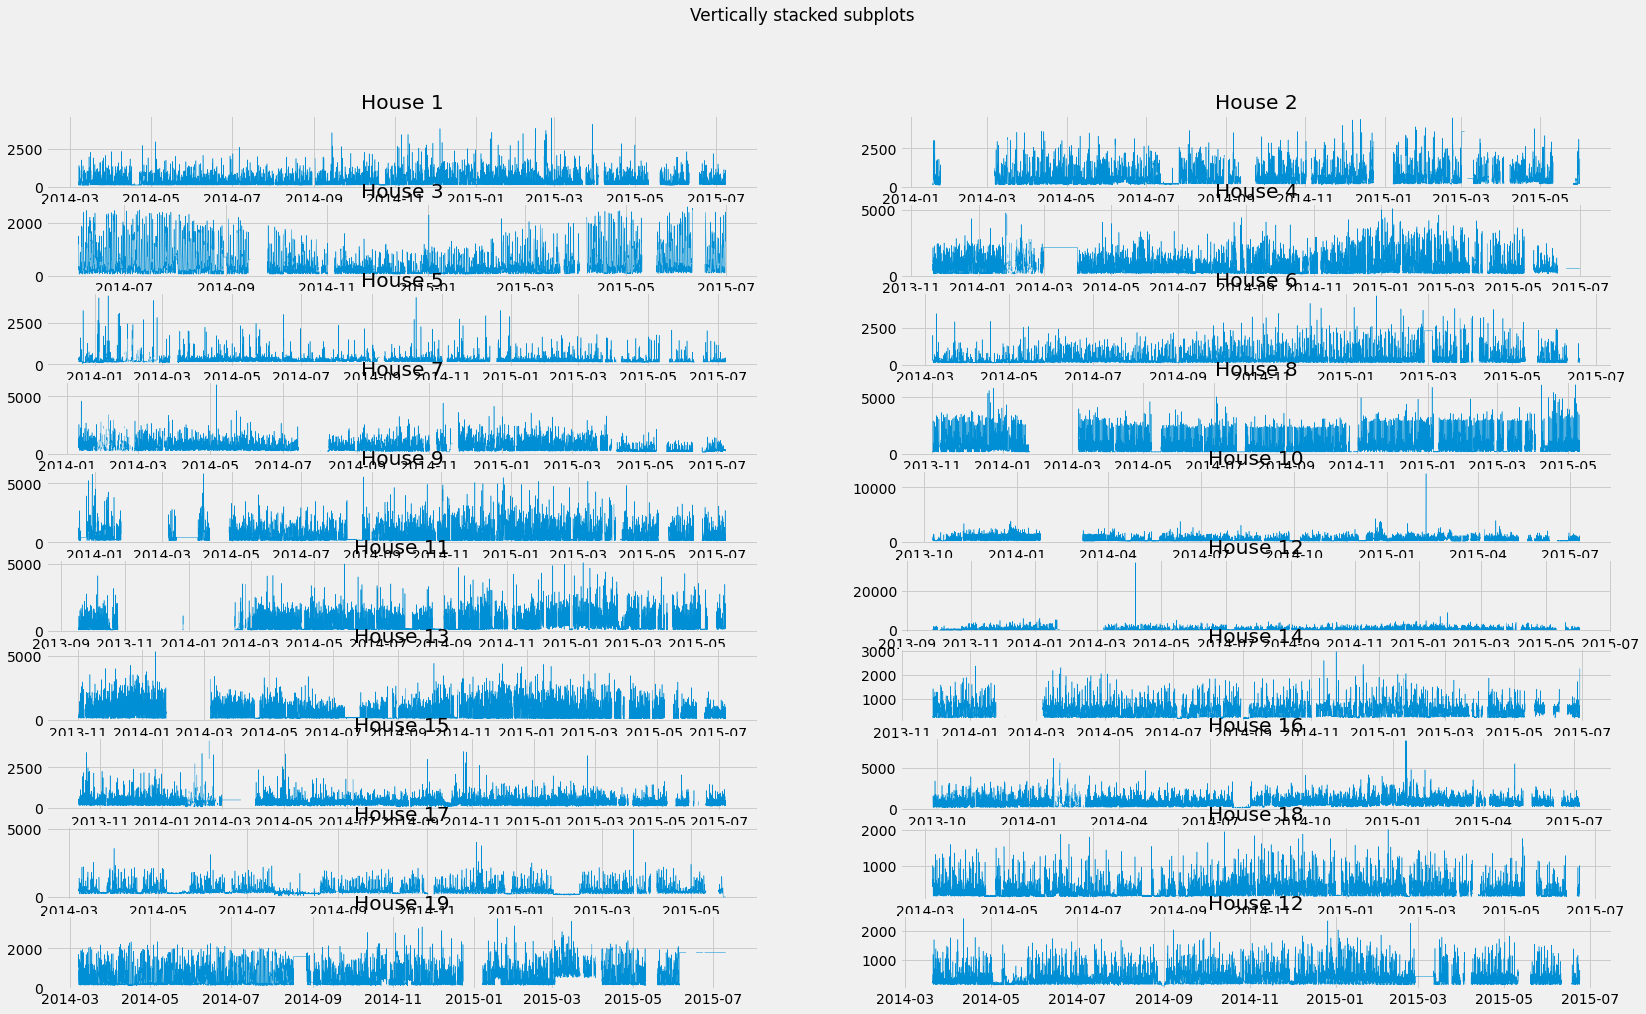

In [26]:
fig, axs = plt.subplots(10,2)
fig.suptitle('Vertically stacked subplots')
axs[0,0].plot(dataframes_list[0]['Aggregate'], lw=0.5)
axs[0,0].set_title("House 1")
axs[0,1].plot(dataframes_list[1]['Aggregate'], lw=0.5)
axs[0,1].set_title("House 2")
axs[1,0].plot(dataframes_list[2]['Aggregate'], lw=0.5)
axs[1,0].set_title("House 3")
axs[1,1].plot(dataframes_list[3]['Aggregate'], lw=0.5)
axs[1,1].set_title("House 4")
axs[2,0].plot(dataframes_list[4]['Aggregate'], lw=0.5)
axs[2,0].set_title("House 5")
axs[2,1].plot(dataframes_list[5]['Aggregate'], lw=0.5)
axs[2,1].set_title("House 6")
axs[3,0].plot(dataframes_list[6]['Aggregate'], lw=0.5)
axs[3,0].set_title("House 7")
axs[3,1].plot(dataframes_list[7]['Aggregate'], lw=0.5)
axs[3,1].set_title("House 8")
axs[4,0].plot(dataframes_list[8]['Aggregate'], lw=0.5)
axs[4,0].set_title("House 9")
axs[4,1].plot(dataframes_list[9]['Aggregate'], lw=0.5)
axs[4,1].set_title("House 10")
axs[5,0].plot(dataframes_list[10]['Aggregate'], lw=0.5)
axs[5,0].set_title("House 11")
axs[5,1].plot(dataframes_list[11]['Aggregate'], lw=0.5)
axs[5,1].set_title("House 12")
axs[6,0].plot(dataframes_list[12]['Aggregate'], lw=0.5)
axs[6,0].set_title("House 13")
axs[6,1].plot(dataframes_list[13]['Aggregate'], lw=0.5)
axs[6,1].set_title("House 14")
axs[7,0].plot(dataframes_list[14]['Aggregate'], lw=0.5)
axs[7,0].set_title("House 15")
axs[7,1].plot(dataframes_list[15]['Aggregate'], lw=0.5)
axs[7,1].set_title("House 16")
axs[8,0].plot(dataframes_list[16]['Aggregate'], lw=0.5)
axs[8,0].set_title("House 17")
axs[8,1].plot(dataframes_list[17]['Aggregate'], lw=0.5)
axs[8,1].set_title("House 18")
axs[9,0].plot(dataframes_list[18]['Aggregate'], lw=0.5)
axs[9,0].set_title("House 19")
axs[9,1].plot(dataframes_list[19]['Aggregate'], lw=0.5)
axs[9,1].set_title("House 12")



In [45]:
dataframes_list[0].loc[(dataframes_list[0].index>"2014-07-01")&(dataframes_list[0].index<="2014-07-02")].plot(lw=1)

AttributeError: 'NoneType' object has no attribute 'loc'

In [40]:
def create_features(df):
    """
    Creates time series features from datetime index.
    """
    # df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night']= np.where((df['hour']>=18)|(df['hour']<6),1,0)

In [48]:
[create_features(df) for df in dataframes_list]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [50]:
dataframes_list[1]


,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,night
Time,,,,,,,,,,,,,,,,,,,
2014-01-17 22:00:00,265.242308,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,0.000000,2014-01-17 22:00:00,22,4,1,1,2014,17,17,1
2014-01-17 23:00:00,170.491743,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,0.000000,2014-01-17 23:00:00,23,4,1,1,2014,17,17,1
2014-01-18 00:00:00,170.407328,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,0.000000,2014-01-18 00:00:00,0,5,1,1,2014,18,18,1
2014-01-18 01:00:00,176.224872,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,0.000000,2014-01-18 01:00:00,1,5,1,1,2014,18,18,1
2014-01-18 02:00:00,161.606838,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,0.000000,2014-01-18 02:00:00,2,5,1,1,2014,18,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31 07:00:00,581.003711,0.0,0.0,0.000000,0.011132,0.0,63.445269,52.482375,22.742115,100.736549,2015-05-31 07:00:00,7,6,2,5,2015,151,31,0
2015-05-31 08:00:00,470.336414,0.0,0.0,0.000000,0.029575,0.0,142.548983,52.569316,1.000000,0.000000,2015-05-31 08:00:00,8,6,2,5,2015,151,31,0
2015-05-31 09:00:00,434.966605,0.0,0.0,0.000000,0.012987,0.0,146.461967,52.660482,1.000000,0.000000,2015-05-31 09:00:00,9,6,2,5,2015,151,31,0


In [52]:
#ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [53]:
#Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(dataframes_list[0]['Aggregate'].dropna(),autolag="AIC")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.587650
p-value: 0.000000
